<a href="https://colab.research.google.com/github/fontanads/machine_learning/blob/master/pytorch_labs/PyTorch_Custom_BCE_Loss_and_GradOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Exercise: writing a custom loss function (BCE) and custom optimizer


In this notebook, I create an artificial dataset aiming for binary classification of the datapoints.

I implement Binary-Cross Entropy as a **custom loss function**. The custom loss function *inherits the backward-propagation* method from the main pytorch module.

I also write a very simple **custom optimizer** to update the weights of the network, just to illustrate where to start from when you need to customize your update-rule equations.

The dataset is in 2D for visualization purposes.

**REMARK**: the code is only prepared to run with CUDA (GPU processing support for pytorch). 

It was tested in Google Colab by setting the Runtime type to "GPU". 

In case you try to run in a CPU, remove the '.cuda()' calls where it is used. 

In [0]:
import torch
import torch.nn as nn
from itertools import product

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import time

In [0]:
SEED = 42                             # random gen seed for numpy and torch
use_custom_loss_and_opt = True        # set True if you want to use my custom functions or False for torch's loss and optimizer
learning_rate = 1e-1                  # learning rate for parameter updates
hidden_layer_sizes = [64, 32, 16]   # this is a list of the number of units in each Fully-Connected hidden layer, e.g. [16, 4, 2]
max_epochs = 300                      # maximum number of iterations running over the training set
train_size = 0.9                      # should be in the interval (0,1), it's the relative size of the training set
M = 100000                             # this is the total number of data-points in the dataset
print_status_iters = 10               # print loss val. every 'print_status_iters' iterations during training
xlim, ylim = (10,10)                  # grid limits -xlim to xlim in the x-axis and -ylim to ylim in the y-axis
normalize_X = True                    # a flag to normalize ANN's input data if set True

Next cell is a function to implement data points in the 2D plane.

Data-points $(x,y)$ satisfying the inequality

$r^2 \leq \left[ \dfrac{(x-x_0+n_x)\cos\theta+(y-y_0+n_y)\sin\theta}{a^2}\right]^2 +\left[ \dfrac{(x-x_0+n_x)\sin\theta-(y-y_0+n_y)\cos\theta}{b^2}\right]^2 \leq R^2$ 

belong to the inside of the ellipse and will be labeled $1$. If the data point does not satisfy the inequality, it gets label $0$. 

Note that the values $n_x$ and $n_y$ are noise following Gaussian distribution $\cal{N}(0,\sigma^2)$.

In [0]:
def elliptical_dataset_gen_func(tuples_xy):
  R = max(xlim,ylim)/2     # larger radius if circle
  r = max(0,min(2.5,R-.1))   # smaller radius if circle
  a,b = (1.2,.8)             # scaling factors of x and y, respectively  (increasing it causes x and y to shrink)
  x0, y0= (-1, 1)            # ellipse center 
  sigma2 = 5e-2              # perturbation variance ('strength') that may cause a data-point to deviate from its intended (x,y) location 
  theta = 45*(np.pi/180)     # ellipse rotation angle with respect to the horizontal axis
  
  def noise_sample():
    return np.sqrt(sigma2)*np.random.randn(1)

  def offset(u,u0):
    return (u -u0 + noise_sample())
  
  def factor(w,u,theta,s):
    return (w*np.cos(theta) + u*np.sin(theta))**2/(s**2)
  
  def elipse(x,y):
    w = offset(x,x0)
    u = offset(y,y0)
    return factor(w,u,theta,a) + factor(u,-w,theta,b)

  dataset = [(x,y,1) if  r**2 <= elipse(x,y) <= R**2 else (x,y,0) for x,y in tuples_xy ]
  return np.array(dataset)

Next, we fill the 2D grid with the cartesian product of linearly spaced x and y vectors. 

The $(x,y)$ tuples are input to the datset generation, that outputs a list of tuples $(x,y,\text{label})$.

The figure shows the data of class $0$ (outside the ellipse) in blue while points of class $1$ (inside the ellipse) are in red.

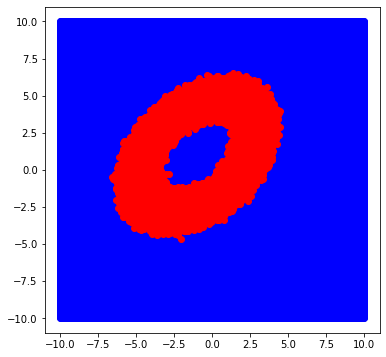

In [6]:
M_int = int(np.sqrt(M))
np.random.seed(SEED)
x = np.linspace(-xlim,xlim,M_int)
y = np.linspace(-ylim,ylim,M_int)
cartesian_xy = product(x,y)
dataset = elliptical_dataset_gen_func(cartesian_xy)

plt.figure(figsize=(6,6))
plt.scatter(dataset[dataset[:,2]==0,0],dataset[dataset[:,2]==0,1],color='b')
plt.scatter(dataset[dataset[:,2]==1,0],dataset[dataset[:,2]==1,1],color='r')

In [7]:
dataset = torch.FloatTensor(dataset).cuda() # convert dataset to FloatTensor matrix (an then for CUDA)
dataset.shape

torch.Size([99856, 3])

Next is the design of the custom Artificial Neural Network (ANN) Model.

It is created using a class, so that it inherits properties of torch's "`nn.Module`" class.

In the initialization, the inputs are used to build the standard hidden layers. In this example, I fixed each hidden layer  to be

>  $\mathbf{h}=\mathbf{W}^T\mathbf{x}$ (*FC layer*) $\to$ $\mathbf{a}^\prime =$ReLU$\left(\mathbf{h}\right)$ $\to$ $\mathbf{a}$=BatchNorm$(\mathbf{a})$

and the final layer is just a wrap-up 
> ${h}=\mathbf{w}^T\mathbf{x}$ (*FC layer*) $\to$ $\hat{y}=\sigma({h})$ (*Sigmoid activation*)

so that the output is a scalar between $0$ and $1$.


In [0]:
class MyModel(nn.Module):
  def __init__(self, n_features, n_classes, layer_sizes):
    super().__init__()
    layers_list = []
    n_in = n_features
    for n_out in layer_sizes:
      layers_list.append(nn.Linear(n_in, n_out)) # FC layer
      layers_list.append(nn.ReLU(inplace=True))  # ReLU activation function
      layers_list.append(nn.BatchNorm1d(n_out))  # Batch Normalization
      n_in = n_out
    # layers_list.append(nn.Linear(layer_sizes[-1], n_classes)) # final layer for CrossEntropy
    layers_list.append(nn.Linear(layer_sizes[-1], 1))           # final layer for BCE
    layers_list.append(nn.Sigmoid())          # final activation function
    self.layers = nn.Sequential(*layers_list) # network object  
  def forward(self,x):
    x = self.layers(x)
    return x

Next, the loss function is defined.

It is important to observe that:
- the function must be writen using torch's Tensor operations and related functions
- the output must be a scalar (loss)

In this example, I chose to write the simple Binary Cross-Entropy for the evaluation of a binary classification.

In [0]:
class MyBynaryCrossEntropyLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,output,target):
    vec_ce = -target*torch.log(output + 1e-10) - (1-target)*torch.log(1-output + 1e-10) 
    return torch.mean( vec_ce )

Finally, the custom optimizer is described below.

It inherits from torch's `'optim.Optimizer'` class.

Initialization requires a dictionary with fixed hyperparameters. In this example, I only use the learning rate. For other optimizer, other hyperparameters such as `'betas'`, `'eps'`,  `'weight_decay'`, `'amsgrad'` may also be initialized.

The **`step()`** method is where the network's parameter-update equations will be customized. The dictionary **`group`** holds the key "params" for the network adjustable parameters (e.g., the hidden-layer weights). 

Each parameter in `group['params']` holds its own gradient computed after backpropagation. This gradient is used to update its values, using the learning rate and other hyperparametrs initialized in the defaults dictionary.

In [0]:
class MyOptimizer(torch.optim.Optimizer):
  def __init__(self, model_parameters, lr=1e-1):
    self.lr = lr 
    self.params = model_parameters
    defaults = {'lr':lr} # dictionary following structure group_name:param_values
    super().__init__(model_parameters,defaults)

  def step(self, closure=None):
    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue
        d_p=p.grad
        p.data.add_(-group['lr'], d_p) 
        # remark: I had trouble using the in-place operation in the leaf-variable p, 
        # so I modified to update the data of the tensor directly

From here on, standard torch training and test procedures take place.

In the next cell, I use torch's `random_split` function to get generators for the train and test set.

Since the dataset is not so large, I alredy extracted each subset into `(X_train, y_train)` and `(X_test, y_test)` variables.

An optional normalization is also used for the input variables. But note that it depends only on the `train_set` to avoid *data leakage*.

In [0]:
train_len = int(train_size*dataset.shape[0])
test_len = dataset.shape[0]-train_len
train_set, test_set = torch.utils.data.random_split(dataset, [train_len,test_len])

X_train = train_set[:][:,:-1]

norm_factor = torch.max(X_train.std(axis=0)) if normalize_X else 1 

X_train = X_train/norm_factor
y_train = train_set[:][:,-1]
X_test  = test_set[:][:,:-1]/norm_factor
y_test  = test_set[:][:,-1]

Next, the custom Model is instantiated.

Depending on what setting you have chosen, custom loss function and custom optimizer will be used. 

Otherwise, torch's `BCELoss()` and `SGD()` optimizer will be used.

In [0]:
Model = MyModel(X_train.shape[1], 2, hidden_layer_sizes)
Model.cuda()

if not use_custom_loss_and_opt:
  criterion = nn.BCELoss(   ) 
  optimizer = torch.optim.SGD(Model.parameters(), lr=learning_rate)
else:
  criterion = MyBynaryCrossEntropyLoss( )
  optimizer = MyOptimizer(Model.parameters(), lr=learning_rate)

In [13]:
print(f'Model {Model}',f'Criterion: {criterion}',f'Optimizer: {optimizer}',sep=2*'\n')

Model MyModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=16, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Criterion: MyBynaryCrossEntropyLoss()

Optimizer: MyOptimizer (
Parameter Group 0
    lr: 0.1
)


Here is the standard torch training loop.

In [14]:
torch.manual_seed(SEED)
losses=[]
start_time = time.time()
for i in range(max_epochs):
    y_pred = Model(X_train).reshape(train_len) # forward-prop in network
    loss = criterion(y_pred,y_train )          # loss calculation
    losses.append(loss)                        # save loss
    optimizer.zero_grad()                      # reset gradients
    loss.backward()                            # backprop
    optimizer.step()                           # params update
    
    if i%print_status_iters==1: # print status
        duration = time.time() - start_time 
        print(f'epoch {i} and loss is {loss:5.6f} (runtime: {duration:10.4f} sec)')
        
duration = time.time() - start_time 
print(f'train took {duration/60} min.')

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


epoch 1 and loss is 0.736205 (runtime:     0.0401 sec)
epoch 11 and loss is 0.500883 (runtime:     0.3165 sec)
epoch 21 and loss is 0.382628 (runtime:     0.9834 sec)
epoch 31 and loss is 0.302141 (runtime:     1.6426 sec)
epoch 41 and loss is 0.259338 (runtime:     2.3017 sec)
epoch 51 and loss is 0.227971 (runtime:     2.9607 sec)
epoch 61 and loss is 0.162084 (runtime:     3.6196 sec)
epoch 71 and loss is 0.153490 (runtime:     4.2790 sec)
epoch 81 and loss is 0.152159 (runtime:     4.9379 sec)
epoch 91 and loss is 0.152574 (runtime:     5.5971 sec)
epoch 101 and loss is 0.139762 (runtime:     6.2562 sec)
epoch 111 and loss is 0.102095 (runtime:     6.9156 sec)
epoch 121 and loss is 0.089894 (runtime:     7.5746 sec)
epoch 131 and loss is 0.097496 (runtime:     8.2337 sec)
epoch 141 and loss is 0.090645 (runtime:     8.8926 sec)
epoch 151 and loss is 0.087630 (runtime:     9.5514 sec)
epoch 161 and loss is 0.091800 (runtime:    10.2101 sec)
epoch 171 and loss is 0.089163 (runtime:  

In [15]:
y_pred

tensor([0.9800, 0.4094, 0.0058,  ..., 0.0160, 0.0053, 0.0049], device='cuda:0',
       grad_fn=<ViewBackward>)

Plot of the loss function during training (y-axis in `log` scale).

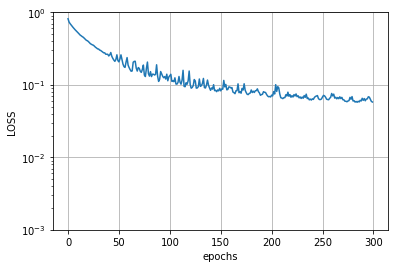

In [16]:
plt.plot(range(max_epochs), losses)
plt.xlabel('epochs')
plt.ylabel('LOSS')
plt.yscale('log')
plt.ylim([1e-3,1e0])
plt.grid()
plt.show()

Here, predictions are made with the test set.

In [17]:
with torch.no_grad():
    y_val = Model(X_test).reshape(test_len)
    loss  = criterion(y_val, y_test)
loss

tensor(0.0581, device='cuda:0')

Then we plot the true values vs. the predictions. 

Note that the Sigmoid's output is a soft-value between $0$ and $1$.

We can make a hard decision by rouding then or we can plot the confidence using a color gradient. 

In [0]:
#y_pred = torch.argmax(y_val, axis=1).cpu().numpy() # cross-entropy output needs 2 classes
y_pred_hard = y_val.round().cpu().numpy()
y_pred_soft = y_val.cpu().numpy().round(decimals=1)

Text(0.5, 0, 'sigmoid output')

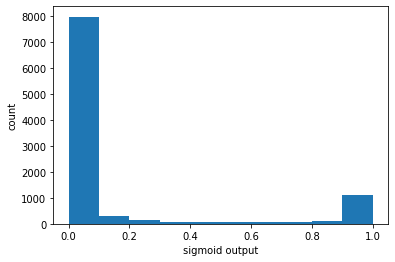

In [19]:
plt.hist(y_pred_soft) # just a histogram to quick view the distribution of soft prediction-values
plt.ylabel('count')
plt.xlabel('sigmoid output')

KeyboardInterrupt: ignored

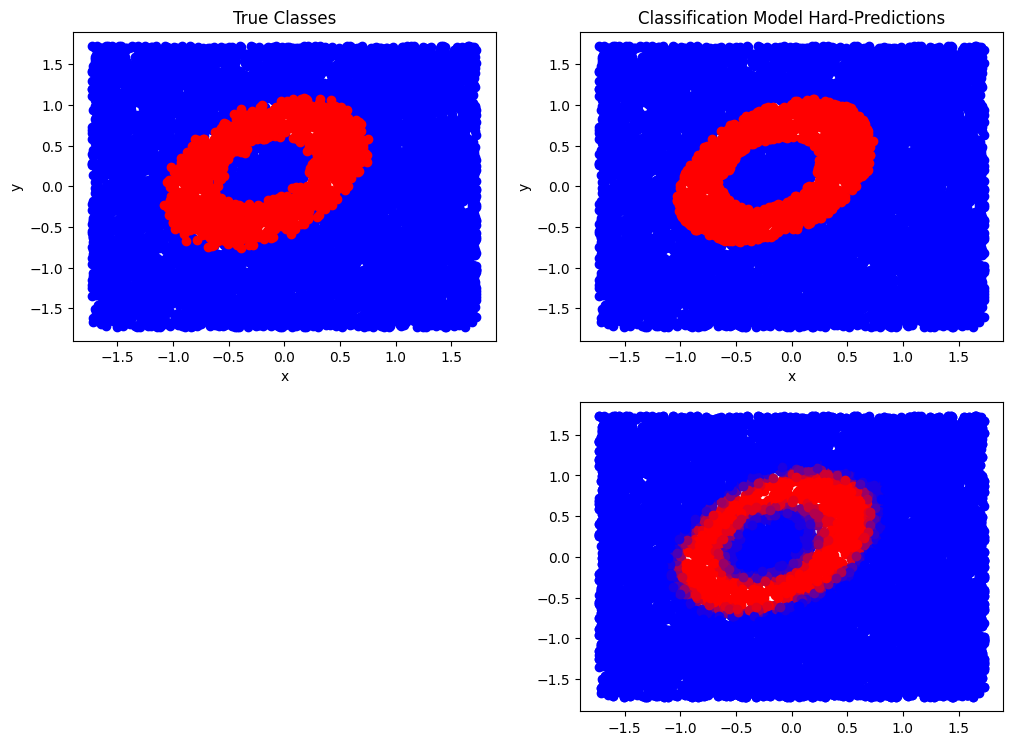

In [20]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2) # Create 2x2 sub plots

plt.figure(figsize=(12, 9), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(gs[0, 0])
plt.scatter(X_test.cpu()[y_test==0,0],X_test.cpu()[y_test==0,1],color='b')
plt.scatter(X_test.cpu()[y_test==1,0],X_test.cpu()[y_test==1,1],color='r')
plt.xlabel('x'), plt.ylabel('y')
plt.title('True Classes')

plt.subplot(gs[0, 1])
plt.scatter(X_test.cpu()[y_pred_hard==0,0],X_test.cpu()[y_pred_hard==0,1],color='b')
plt.scatter(X_test.cpu()[y_pred_hard==1,0],X_test.cpu()[y_pred_hard==1,1],color='r')
plt.xlabel('x'), plt.ylabel('y')
plt.title('Classification Model Hard-Predictions')

plt.subplot(gs[1, 1])
plt.scatter(X_test.cpu()[y_pred_hard==0,0],X_test.cpu()[y_pred_hard==0,1],color='b')
for i in range(len(y_pred_soft)):
  plt.scatter(X_test.cpu()[i,0],X_test.cpu()[i,1],color=(y_pred_soft[i],0,1-y_pred_soft[i]))
plt.xlabel('x'), plt.ylabel('y')
plt.title('Classification Model Soft-Predictions')

plt.show()

Here we evaluate the classification metric.

First, a confusion matrix is shown.

In [0]:
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
y_true = y_test.cpu().numpy()

In each row of the confusion matrix, we see absolute number of hits and errors.

Note that in row $0$, the first item is the number of hits, 

while in row $1$, the second item is the number of hits.

In [23]:
confusion_matrix(y_true, y_pred_hard)

array([[8475,  108],
       [ 116, 1287]])

Instead of absolute number of erros, we can view the confusion matrix with the percentage of hits and errors for each class.

In [24]:
np.around(100*confusion_matrix(y_true, y_pred_hard, normalize='true'),decimals=2) # row (label) normalized

array([[98.74,  1.26],
       [ 8.27, 91.73]])

Other classification metrics are reported with the following `sklearn` function.

In [25]:
print(
    classification_report(y_true, y_pred_hard, target_names=['0','1'])
)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8583
           1       0.92      0.92      0.92      1403

    accuracy                           0.98      9986
   macro avg       0.95      0.95      0.95      9986
weighted avg       0.98      0.98      0.98      9986



At last, some examples of predicted  vs. True classification values.

In [26]:
for i in np.random.randint(low=0, high=test_len, size=10):
    pred_val  = y_pred_hard[i] # torch.argmax(y_val[i])
    soft_val  = y_pred_soft[i]
    true_val  = y_test[i].long()
    print(f'PREDICTED (HARD/SOFT): {int(pred_val)}/{soft_val:.2f} TRUE: {true_val}  | Input.: {i}) \n')

PREDICTED (HARD/SOFT): 0/0.00 TRUE: 0  | Input.: 7575) 

PREDICTED (HARD/SOFT): 0/0.00 TRUE: 0  | Input.: 246) 

PREDICTED (HARD/SOFT): 0/0.00 TRUE: 0  | Input.: 1669) 

PREDICTED (HARD/SOFT): 1/1.00 TRUE: 1  | Input.: 4859) 

PREDICTED (HARD/SOFT): 0/0.00 TRUE: 0  | Input.: 4787) 

PREDICTED (HARD/SOFT): 0/0.00 TRUE: 0  | Input.: 3537) 

PREDICTED (HARD/SOFT): 0/0.00 TRUE: 0  | Input.: 3019) 

PREDICTED (HARD/SOFT): 1/1.00 TRUE: 1  | Input.: 5570) 

PREDICTED (HARD/SOFT): 0/0.00 TRUE: 0  | Input.: 963) 

PREDICTED (HARD/SOFT): 0/0.00 TRUE: 0  | Input.: 2756) 

